In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
# import importlib
# import seaborn as sns

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

### Load Data

In [34]:
file_list = user_path + '/PHYS469/saturation_spectroscopy/interim_data_list.txt'
oct10_raw_data = {}

with open(file_list, 'r') as file_names:
    # Go through good data files
    for file_path in file_names:
        file_path = file_path.strip()
        # Read the lines of the file
        with open(user_path+file_path, 'r') as f:
            lines = f.readlines()
        # Find end of the header (the line that starts with 'x ys')
        for i, line in enumerate(lines):
            if line.startswith('x	y'):
                lines_to_skip = i
                break

        # Read data (skip header)
        data = np.genfromtxt(user_path+file_path, skip_header=lines_to_skip, names=True, missing_values='nan', filling_values=0)
        reshaped_data = np.vstack([data[field] for field in data.dtype.names]).T

        # Add to a dict
        file_dict = {label: reshaped_data[:,i] for i,label in enumerate(data.dtype.names)}
        oct10_raw_data[file_path[53:57]] = file_dict

### Plot Data

In [113]:
data_time = oct10_raw_data['run3']['x']
data_voltage = -oct10_raw_data['run3']['y3']

In [114]:
def gaussian(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d

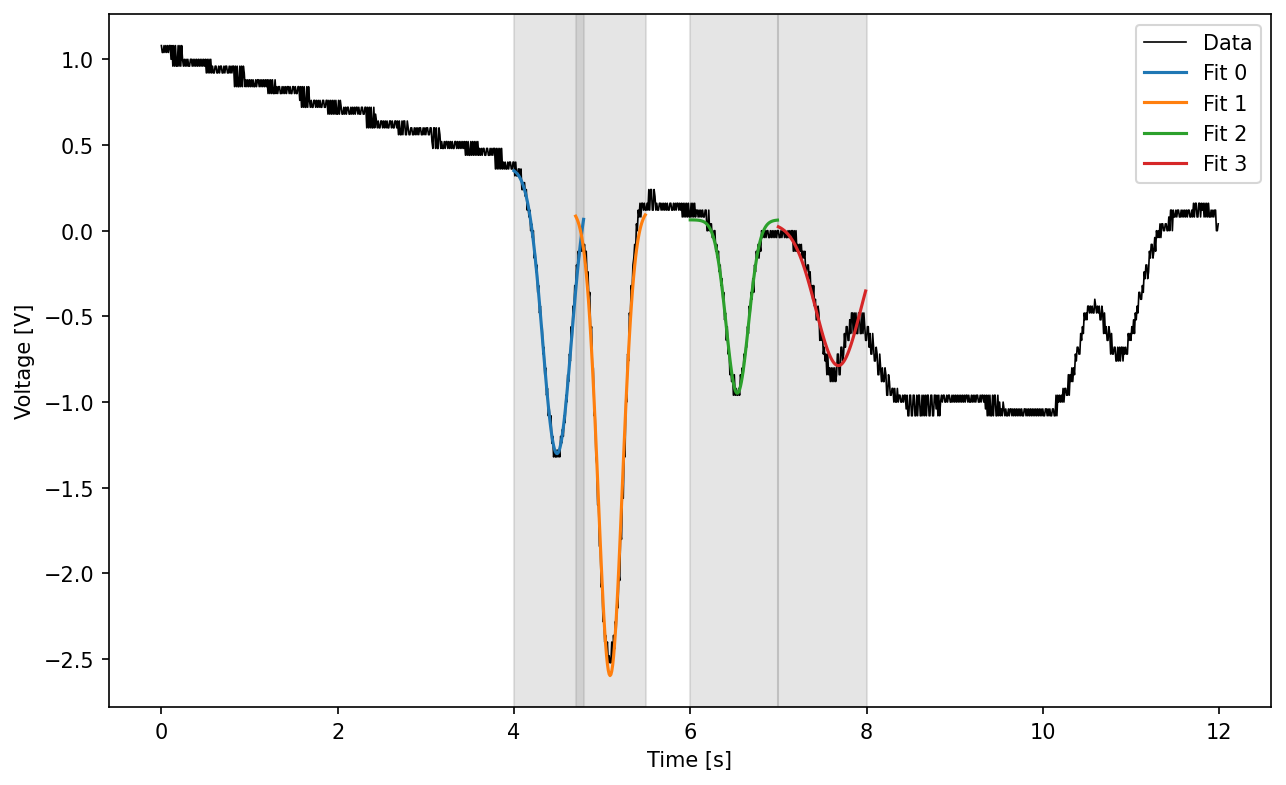

In [136]:
time_multiplier = 1000

# Get data slices for each dip
slice_edges = np.array([0.004, 0.0048, 0.0047, 0.0055, 0.006, 0.007, 0.007, 0.008])
slice_indices = [np.argmin(np.abs(edge - data_time)) for edge in slice_edges]

# Figure
plt.figure(figsize=(10,6), dpi=150)

# Plot data
plt.plot(data_time*time_multiplier, data_voltage, color='k', linewidth=0.8, label = 'Data')

# to vizualize the slices (we dont have to keep this, it was mostly for myself hehe)
for start,stop in zip(slice_edges[:-1:2], slice_edges[1::2]):
    plt.axvspan(start*time_multiplier, stop*time_multiplier, color='gray', alpha=0.2)

# Fit the data
fit_dict = {}
for i,(start,stop) in enumerate(zip(slice_indices[:-1:2], slice_indices[1::2])):
    popt, pcov = opt.curve_fit(gaussian, data_time[start:stop], data_voltage[start:stop], 
                               p0=[-1, data_time[int((stop - start) / 2) + start], 0.0002, -1])
    # Add to dictionary
    fit_dict[f'popt_{i}'] = popt
    fit_dict[f'err_{i}'] = np.sqrt(np.diag(pcov))
    # Plot the fit
    fit_voltage = gaussian(data_time[start:stop], *popt)
    plt.plot(data_time[start:stop]*time_multiplier, fit_voltage, label = f'Fit {i}')
    # put params in plot legend instead?

# Labels
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()

plt.show()

In [ ]:
# all the fit value are saved in fit_dict, in order from left to right (see plot)
# names are popt_0, err_0, popt_1, err_1, etc.

### Calculations

In [57]:
# Constants
k_B = 1.380649e-23  # Boltzmann constant in J/K
T_Celsius = 45.6  # Temperature in Celsius
T_Kelvin = T_Celsius + 273.15  # Convert to Kelvin
mass_85Rb = 1.409993199e-25  # Mass of 85Rb in kg
mass_87Rb = 1.44316060e-25   # Mass of 87Rb in kg

# Convert Celsius to Kelvin
T = T_Kelvin

# Doppler broadening FWHM formula for velocity
def doppler_fwhm(T, mass):
    return np.sqrt(8 * k_B * T * np.log(2) / mass)

# Calculate FWHM for each isotope
fwhm_85Rb = doppler_fwhm(T, mass_85Rb)
fwhm_87Rb = doppler_fwhm(T, mass_87Rb)

print(f'FWHM for 85Rb: {fwhm_85Rb:.2f} m/s')
print(f'FWHM for 87Rb: {fwhm_87Rb:.2f} m/s')

FWHM for 85Rb: 416.02 m/s
FWHM for 87Rb: 411.21 m/s
